In [ ]:
pip install alibi[tensorflow]

In [ ]:
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from time import time
from alibi.explainers import Counterfactual
print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

TF version:  2.12.1
Eager execution enabled:  False


11490434/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28) y_train shape: (60000,)


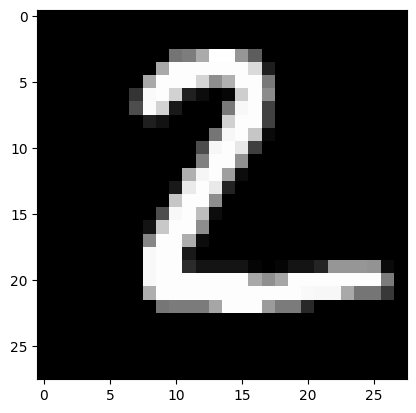

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)
plt.gray()
plt.imshow(x_test[1]);

Prepare data: scale, reshape and categorize

In [ ]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10) y_test shape: (10000, 10)


In [ ]:
xmin, xmax = -.5, .5
x_train = ((x_train - x_train.min()) / (x_train.max() - x_train.min())) * (xmax - xmin) + xmin
x_test = ((x_test - x_test.min()) / (x_test.max() - x_test.min())) * (xmax - xmin) + xmin

## Define and train CNN model

In [ ]:
def cnn_model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x_in)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x_out = Dense(10, activation='softmax')(x)

    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return cnn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Set the directory in Google Drive where you want to save images
save_dir = "/content/drive/My Drive/Courses/DL BU/MNIST/mnist_images"

cnn = cnn_model()
cnn.summary()
cnn.fit(x_train, y_train, batch_size=64, epochs=3, verbose=0)
cnn.save('/content/drive/My Drive/Courses/DL BU/MNIST/mnist_cnn.h5')

Mounted at /content/drive
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                               

Evaluate the model on test set

In [ ]:
cnn = load_model('/content/drive/My Drive/Courses/DL BU/MNIST/mnist_cnn.h5')
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Test accuracy:  0.9873


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


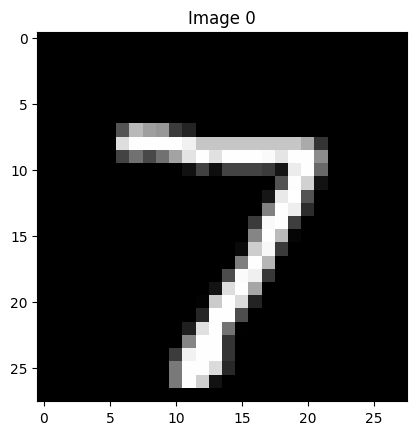

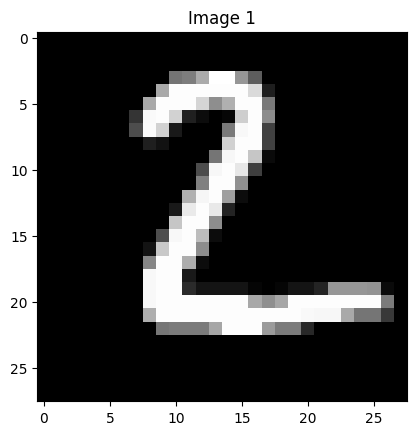

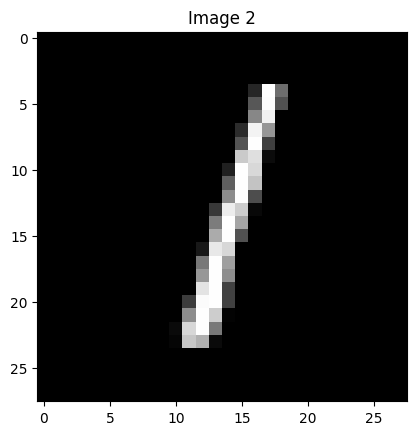

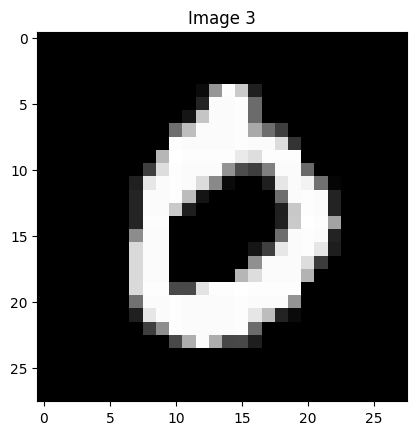

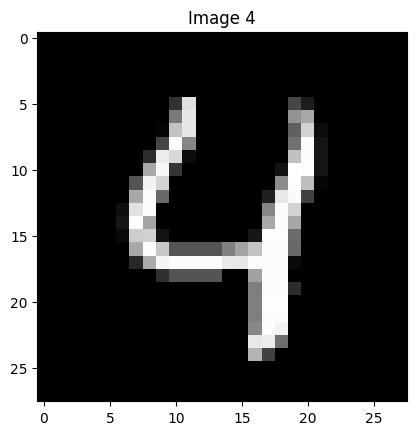

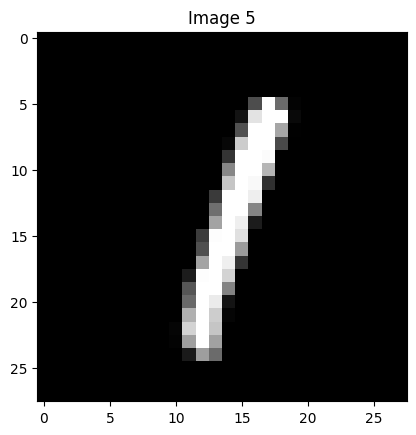

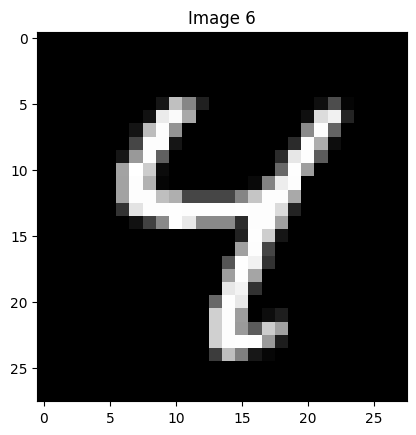

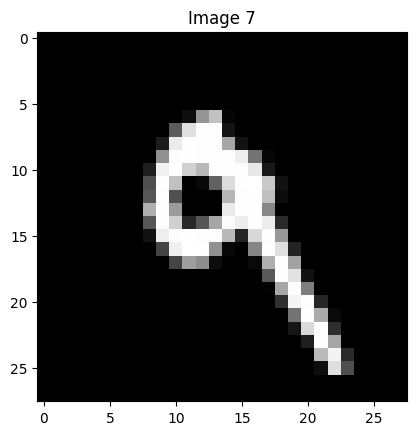

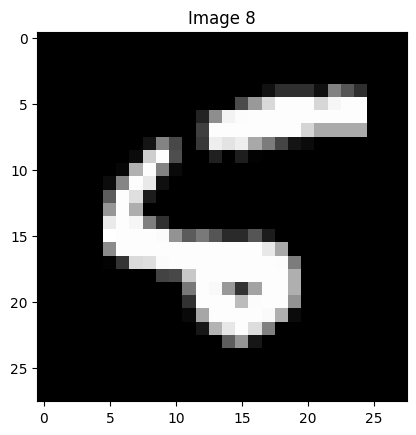

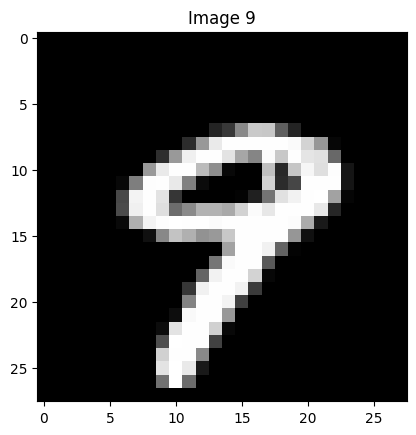

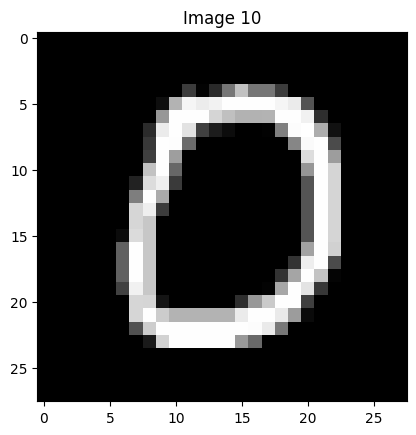

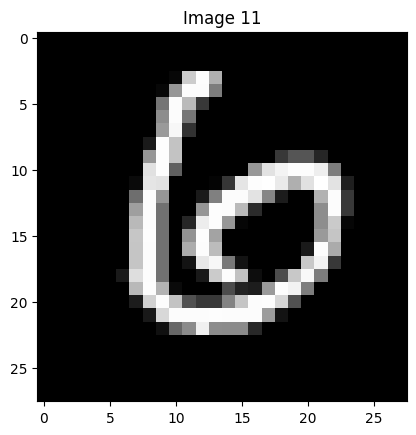

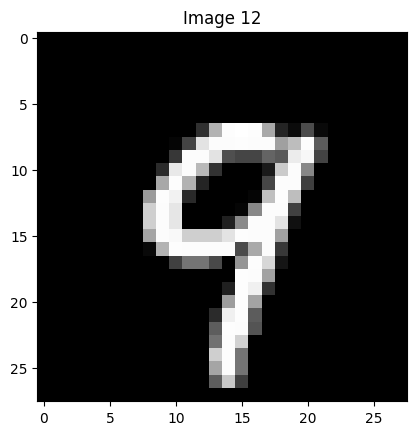

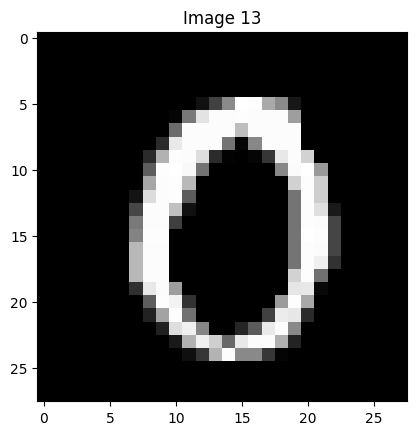

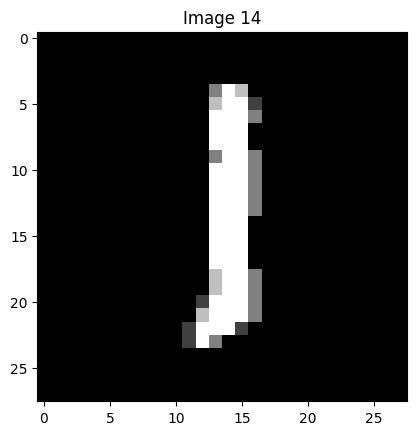

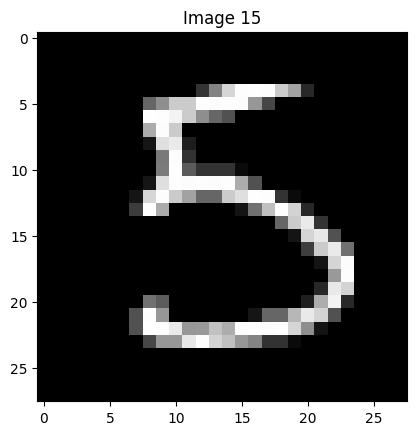

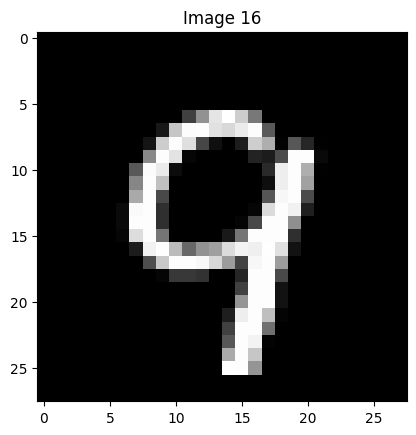

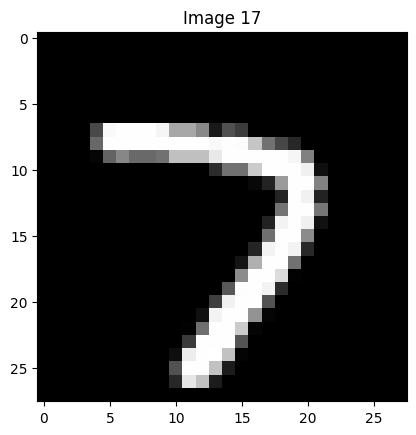

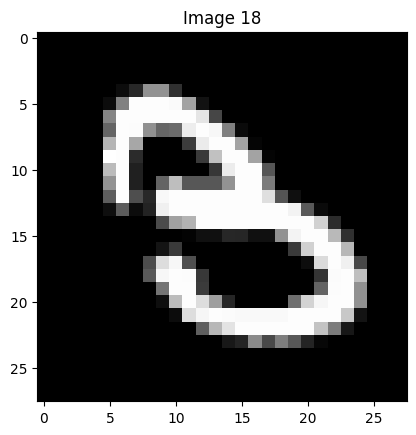

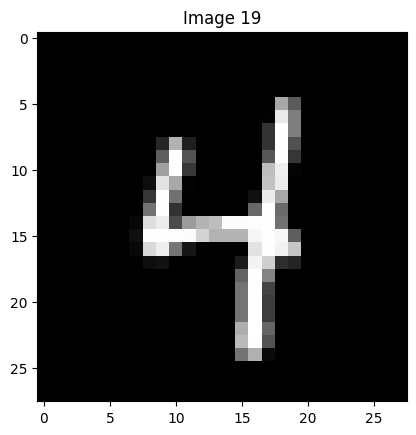

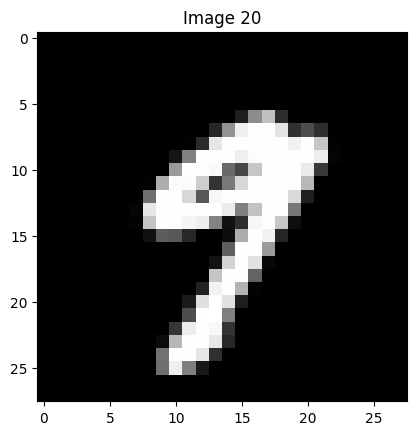

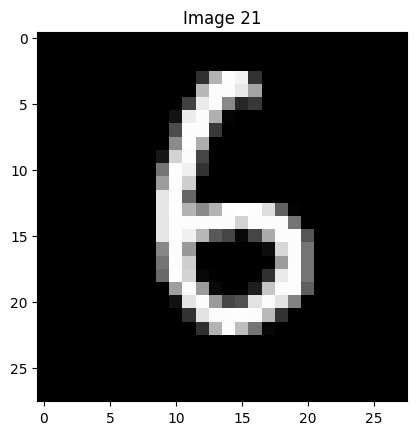

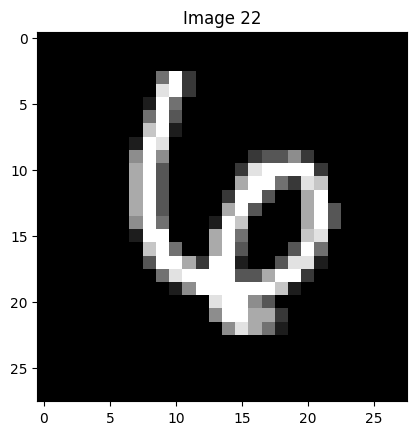

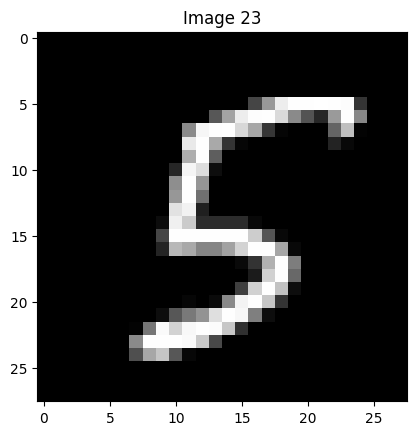

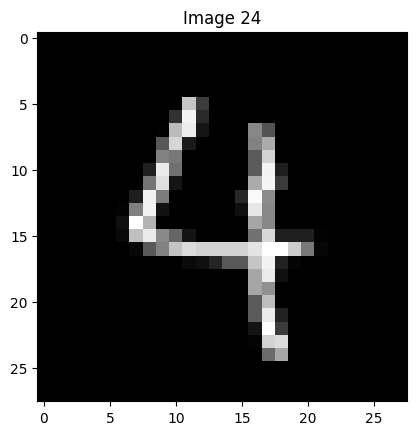

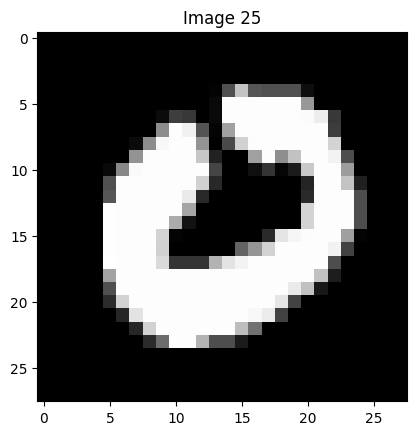

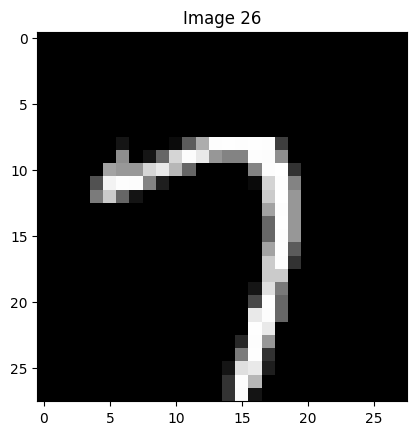

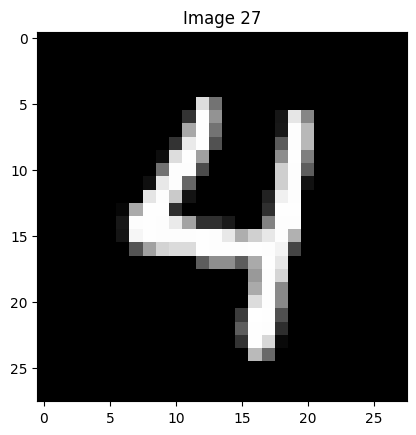

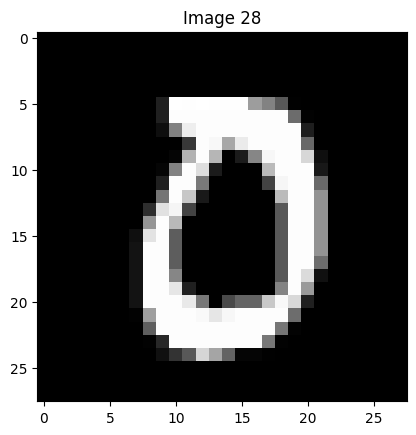

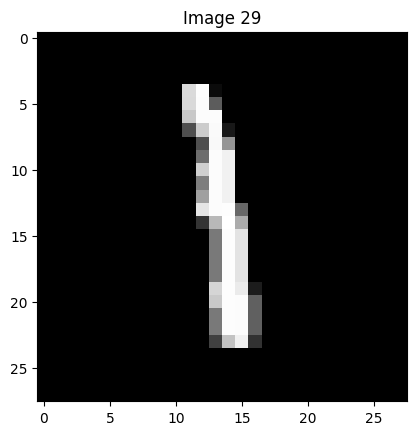

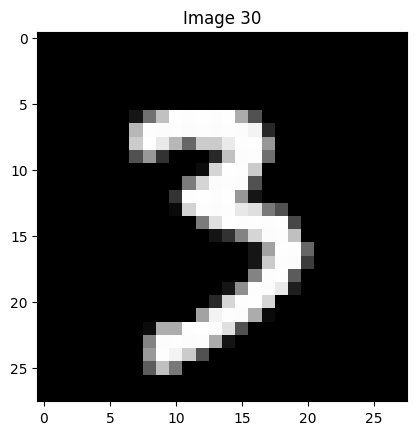

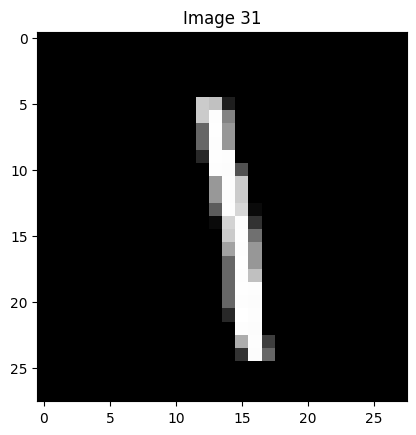

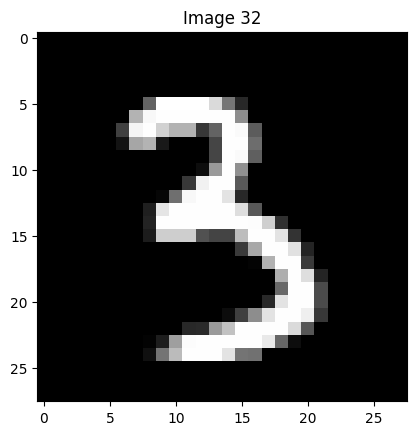

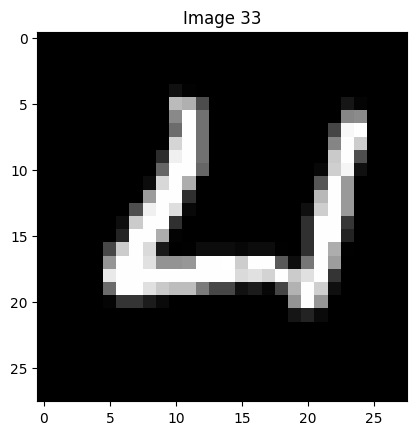

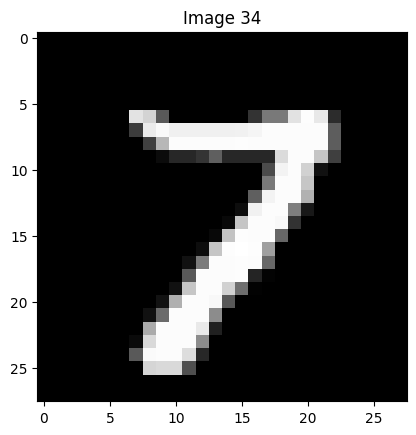

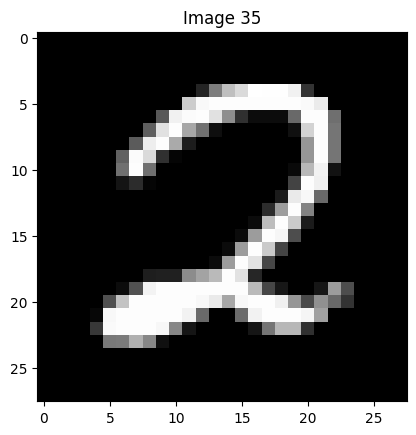

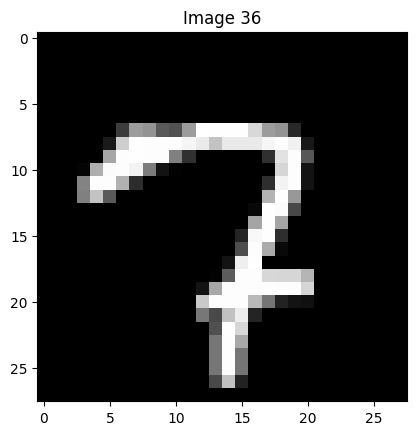

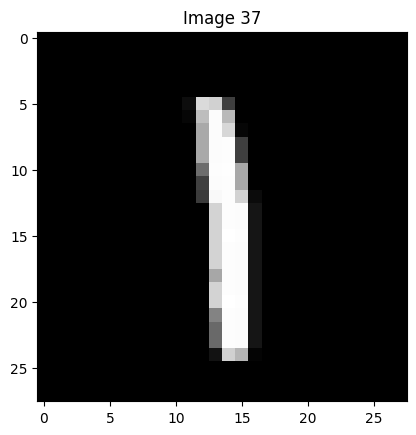

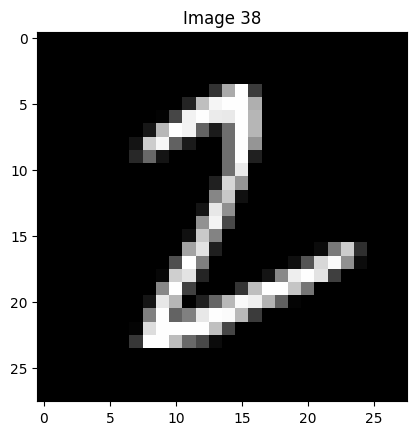

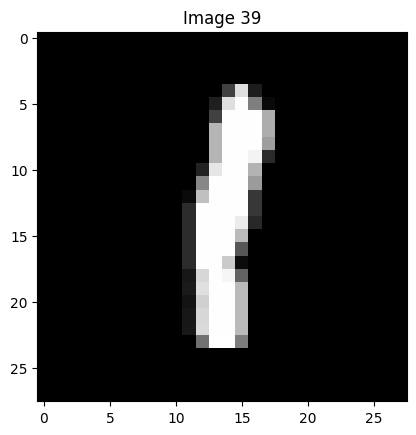

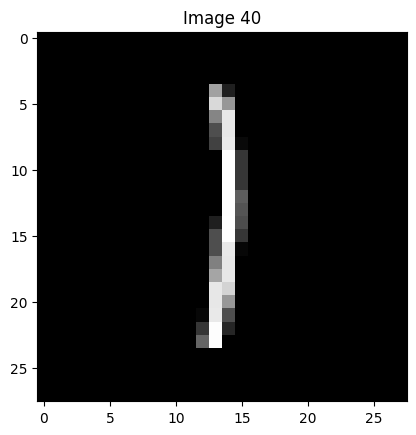

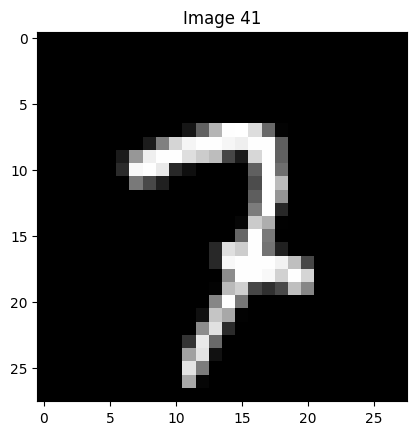

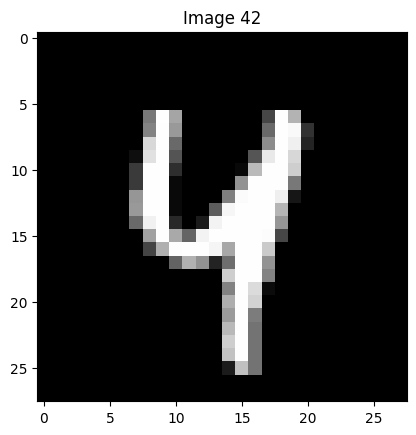

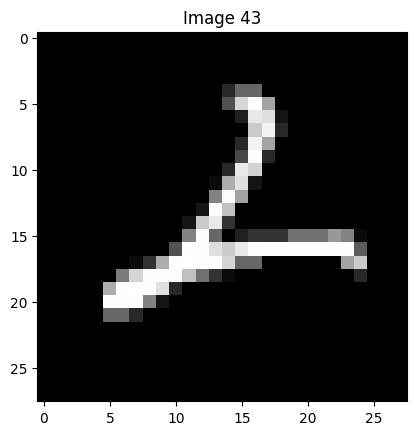

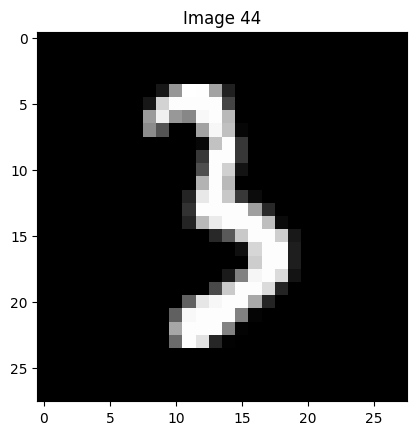

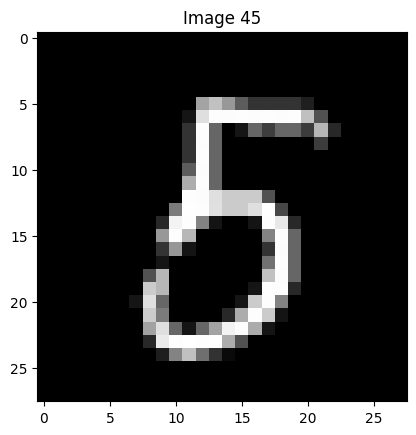

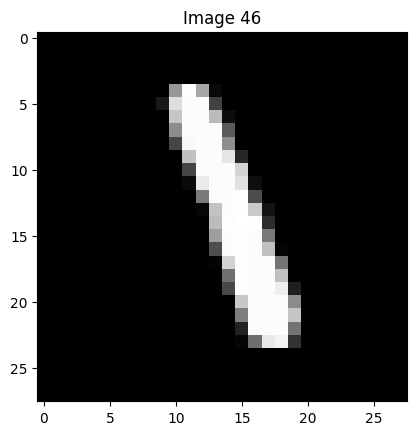

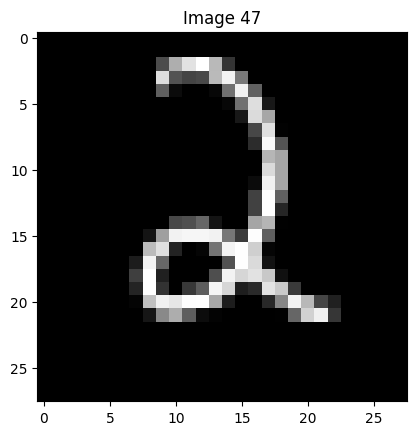

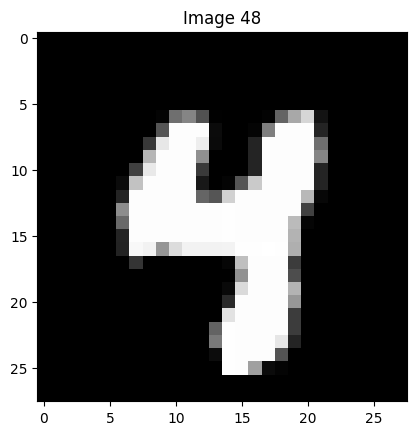

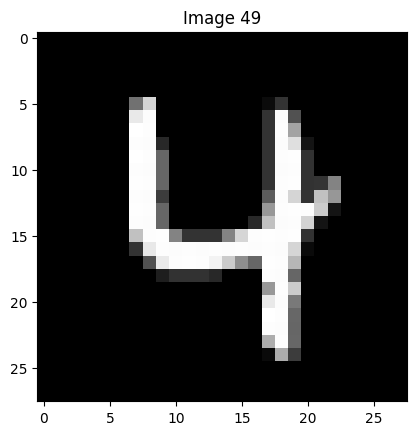

In [ ]:
from google.colab import drive
import matplotlib.pyplot as plt
import os

# Mount Google Drive
drive.mount('/content/drive')

# Set the directory in Google Drive where you want to save images
save_dir = "/content/drive/My Drive/Courses/DL BU/MNIST/mnist_images"
os.makedirs(save_dir, exist_ok=True)

# Assuming x_test is your MNIST test dataset
# Loop through the first 50 images
for i in range(50):
    X = x_test[i].reshape((1,) + x_test[i].shape)

    # Display the image
    plt.imshow(X.reshape(28, 28), cmap='gray')
    plt.title(f"Image {i}")
    plt.show()

    # Save the image
    plt.imsave(os.path.join(save_dir, f"mnist_image_{i}.png"), X.reshape(28, 28), cmap='gray')


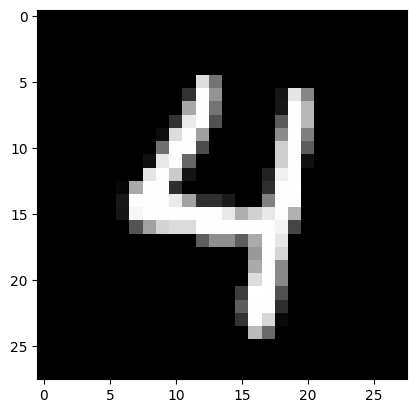

In [ ]:
X = x_test[27].reshape((1,) + x_test[27].shape)
plt.imshow(X.reshape(28, 28));

Counterfactual parameters:

In [ ]:
shape = (1,) + x_train.shape[1:]
target_proba = 1.0
tol = 0.01 # want counterfactuals with p(class)>0.99
target_class = 'other' # any class other than 7 will do
max_iter = 1000
lam_init = 1e-1
max_lam_steps = 10
learning_rate_init = 0.1
feature_range = (x_train.min(),x_train.max())

Run counterfactual:

In [ ]:
# initialize explainer
cf = Counterfactual(cnn, shape=shape, target_proba=target_proba, tol=tol,
                    target_class=target_class, max_iter=max_iter, lam_init=lam_init,
                    max_lam_steps=max_lam_steps, learning_rate_init=learning_rate_init,
                    feature_range=feature_range)

start_time = time()
explanation = cf.explain(X)
print('Explanation took {:.3f} sec'.format(time() - start_time))

Explanation took 10.661 sec


In [ ]:
import csv
from time import time
import matplotlib.pyplot as plt
import os

# Assuming cf is your initialized Counterfactual explainer
# Assuming x_train is your MNIST train dataset
csv_data = []

# Set the directory where you want to save counterfactual images
save_dir = "/content/drive/My Drive/Courses/DL BU/MNIST/counterfactual_images"
os.makedirs(save_dir, exist_ok=True)

# Loop through the desired number of images
for i in range(len(x_train)):
    X = x_test[i].reshape((1,) + x_test[i].shape)

    start_time = time()
    explanation = cf.explain(X)
    elapsed_time = time() - start_time
    print('Explanation for image {} took {:.3f} sec'.format(i, time() - start_time))

    if explanation.cf is not None:
        pred_class = explanation.cf['class']
        proba = explanation.cf['proba'][0][pred_class]

        print(f'Counterfactual prediction for image {i}: {pred_class} with probability {proba}')

        # Append data to CSV list
        csv_data.append([i, pred_class, proba, elapsed_time])

        plt.imshow(explanation.cf['X'].reshape(28, 28))
        plt.title(f"Counterfactual Image {i}")
        plt.show()

        #plt.imsave(os.path.join(save_dir, f"counterfactual_image_{i}.png"), explanation.cf['X'].reshape(28, 28), cmap='gray')


        # Display and/or save the counterfactual image as before...
    else:
        print(f"No valid counterfactual explanation for image {i}")
        # You can choose to append a different set of data for invalid cases
        csv_data.append([i, 'No valid explanation', 0, elapsed_time])


    # Display the counterfactual image


    # Save the counterfactual image


#csv_file_path = '/content/drive/My Drive/Courses/DL BU/MNIST/counterfactuals.csv'
#with open(csv_file_path, 'w', newline='') as file:
    #writer = csv.writer(file)
    #writer.writerow(['Image Index', 'Predicted Class', 'Probability', 'Time Taken (sec)'])
    #writer.writerows(csv_data)

#print(f"CSV file saved at {csv_file_path}")

In [ ]:
csv_file_path = '/content/drive/My Drive/Courses/DL BU/MNIST/counterfactuals.csv'
with open(csv_file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Image Index', 'Predicted Class', 'Probability', 'Time Taken (sec)'])
    writer.writerows(csv_data)

print(f"CSV file saved at {csv_file_path}")

CSV file saved at /content/drive/My Drive/Courses/DL BU/MNIST/counterfactuals.csv


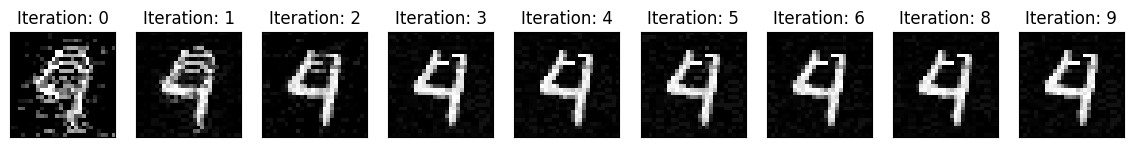

In [ ]:
n_cfs = np.array([len(explanation.all[iter_cf]) for iter_cf in range(max_lam_steps)])
examples = {}
for ix, n in enumerate(n_cfs):
    if n>0:
        examples[ix] = {'ix': ix, 'lambda': explanation.all[ix][0]['lambda'],
                       'X': explanation.all[ix][0]['X']}
columns = len(examples) + 1
rows = 1

fig = plt.figure(figsize=(16,6))

for i, key in enumerate(examples.keys()):
    ax = plt.subplot(rows, columns, i+1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(examples[key]['X'].reshape(28,28))
    plt.title(f'Iteration: {key}')